# Data visualization for quench data

In [3]:
#Data processing
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from nptdms import TdmsFile #Process ramping file


Bad key "text.kerning_factor" on line 4 in
/uscms_data/d3/dhoang/miniconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [4]:
def read_data_from_single_file(filepath):
    """Read in quench data from a given file, return a pandas dafa frame"""
    
    data_dict= {}
    
    with open(filepath) as f:
        content = f.readlines()
    #Remove`\n` at the end of each line
    content = [x.strip() for x in content]
    
    column_names = content[0].split(" ")
    data = [content[i].split("   ") for i in range(1, len(content))] 
    
    for i in range(len(column_names)):
        data_dict[column_names[i]] = [float(x[i]) for x in data]
        
    data_frame = pd.DataFrame(data_dict)
    
    return data_frame

def read_quench_data(area_path, quench_name):
    """
    Read the quench data from the provided file path, note that there are five quenches so we need to concatenate them together.
    Just need to provide the quench's name, for e.g: "./data/mqxfs1b.Quench.161011115654"
    """
    
    data_list = []
    
    
    num_file = 0 #Number of separate data files for this quench, assuming at least one
    
    for filename in os.listdir(area_path):
        if filename.startswith(quench_name) and not filename.endswith(".tar.gz"):
            #print("Reading file ... " + filename)
            if num_file == 0:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename)) #read first file separately
                except:
                    pass
            else:
                try:
                    data_list.append(read_data_from_single_file(area_path + filename).drop(columns = ["time"])) #Time is already saved in the first file
                except:
                    pass
            num_file += 1
                                 
    #print("Total number of data files for {}: ".format(quench_name), num_file)
    
    if len(data_list) != 0:
        data = pd.concat(data_list, axis = 1) #Concatenate all data files together
        return data
    else:
        print("Returning None due to file errors in " + quench_name)
        return None

def read_all_quench_in_area(area_path):
    """
    Read all quench's files in the area and return a dictionary of different quench's data. name is the magnet's name
    """
    data = {}
    
    index = 1 #For indexing different quench

    for filename in os.listdir(area_path):
        if filename.endswith(".tar.gz"): 
            #print("Reading data from ... " + filename[0:-7])
            data[filename[0:-7]] = read_quench_data(area_path, filename[0:-7])
            index += 1
            
    #print("Completed. There are {} quenches in total.".format(str(index - 1)))
    
    return data

def plot_variables_with_time(data, variables = None, time_range = None):
    """
    Take a data frame, and plot all other variables with time.
    Optional argument: time_range to specify the range to plot, default is to plot all time. Example argument
    is (start_time, end_time)
    """
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    if variables:
        for variable in variables:
            plt.figure(figsize=(20,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()
        
    else:      
        #If variables not specified then just plot all 
        for variable in data.columns[1:]:
            plt.figure(figsize=(25,2))
            plt.plot(data["time"], data[variable])
            plt.xlabel("Time (s)")
            plt.title("Variable {}".format(variable))
            plt.show()

def plot_statistics(data, variables = None, time_range = None, window = 100):
    """Take a data frame and plot the variable with its moving average and real data in the specified range, if
    variables are not specified then just plot all variables by default"""
    #Pickout the data
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    def plot_signal_and_statistics(variable):
        # Plotted by calculating Simple Moving Average (SMA)
        plt.figure(figsize=(20,2))
        
        plt.plot(data["time"], data[variable], label = "Signal with noise")
        
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).mean(),label = "Moving average")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).min(),label = "Moving min")
        #plt.plot(data["time"], data.loc[:, variable].rolling(window=window).max(),label = "Moving max")
        plt.legend(loc = "best")
        plt.xlabel("Time (s)")
        plt.title("Variable {}".format(variable))
        plt.show()
        

        #Variance
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).std(),
                 label = "Standard Deviation",
                 color = 'red')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Standard Deviation".format(variable))
        plt.show()
        
        #Kurtosis
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).kurt(),
                 label = "Kurtosis",
                 color = 'green')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Kurtosis".format(variable))
        plt.show()
        
        #Skew
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).skew(),
                 label = "Skew",
                 color = 'purple')
        plt.xlabel("Time (s)")
        plt.title("Variable {}'s Skew".format(variable))
        plt.show()
        
        """
        #Quantile
        plt.figure(figsize=(20,2))
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.25), label = "Quantile 25",
                 color = 'red')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.75), label = "Quantile 75",
                 color = 'orange')
        plt.plot(data["time"], data.loc[:, variable].rolling(window=window).quantile(0.50), label = "Quantile 50",
                 color = 'green')
        plt.legend(loc = "best")
        plt.title("Variable {}'s Quantile".format(variable))
        plt.show()
        """
        
    #Plot
    if variables:
        for variable in variables:
            print(variable)
            plot_signal_and_statistics(variable)         
    else:
        for variable in data.columns[1:]:
            print(variable)
            plot_signal_and_statistics(variable)
    
    %reset -f in

def plot_variable(data_dict, variable, time_range = None, window = 100):
    for quench_name in data_dict.keys():
        print("Quench's index: " + quench_name)
        if data_dict[quench_name] is not None:
            if variable[0] in list(data_dict[quench_name].columns):
                plot_statistics(data_dict[quench_name], variables = variable, time_range=time_range, window=window)


########### PROCESS RAMPING DATA ###############
def read_tdms_file(filepath):
    """Read the tdms file from a given path, return a pandas data frame of the tdms file"""
    tdms_file = TdmsFile.read(data_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    #Just the last 3 symbols in columns name matter ('/'_unnamedTask<3>'/'PXI2Slot14/ai0') -> ai0
    #Rename the columns
    rename_map = []
    
    for column in data_frame.columns:
        rename_map.append(column[-4:-1])
    
    data_frame.columns = rename_map
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(data_frame.shape[0]))
    

    #Center around the max value (quench happens at 0 time)
    max_index = data_frame['ai7'].idxmax()
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    data_frame['time'] = time_range
    
    return data_frame

def break_tdms_to_files(file_path):
    """Read the tdms file and break it into several files according to channels in a new directory"""
    tdms_file = TdmsFile.read(file_path)
    
    data_frame = tdms_file.as_dataframe()
    
    del tdms_file
    
    os.mkdir("./data/" + file_path[-10:-5])
    
    for channel in data_frame.columns:
        np.save("./data/{}/{}".format(file_path[-10:-5], channel[-4:-1]), data_frame.loc[:, channel].to_numpy())

def calculate_time(dir_path):
    """Take a tdms file directory path (after the file is broken up), and calculate and output a time file."""
    
    ai7 = np.load(dir_path + "ai7.npy")
    
    #Add time axis relative to the time when quench happens
    time_range = np.asarray(range(ai7.shape[0]))
    
    #Center around the max value (quench happens at 0 time)
    max_index = np.argmax(ai7)
    time_range -= max_index
    time_range = time_range.astype('float32')
    
    #Multiply by datarate
    time_range = np.multiply(time_range, 1e-5, out=time_range, casting="unsafe")
    
    np.save(dir_path + "time", time_range)

def load_channel_and_time(dir_path, channel):
    data_frame = pd.DataFrame(data = {channel: np.load(dir_path + channel + ".npy"),
                                     "time": np.load(dir_path + "time.npy")})
    return data_frame

def plot_channel(data, channel, time_range = None):
    start = min(data["time"])
    end = max(data["time"])
    
    if time_range:
        start = time_range[0]
        end = time_range[1]
        
    data = data[(data["time"] > start) & (data["time"] < end)]
    
    plt.figure(figsize=(20,2))
    plt.plot(data["time"], data[channel])
    plt.title("Variable {}".format(channel))
    plt.show()
    
    %reset -f in

def load_and_plot(dir_path, channel, time_range = None, stat = False, window = 100):
    ai = load_channel_and_time(dir_path, channel)
    
    if stat:
        plot_statistics(ai, variables = [channel], time_range = time_range, window = window)
    else:
        plot_channel(ai, channel, time_range = time_range)
    
    %reset -f in

## 1. MQXFS1D -- 25.Apr.2018 15:37-- Ramp 4

In [5]:
#Path to directory of quenches
normal = "/uscms/home/ntran/scratch0/intelliquench/data/mqxfs1d/"
all_quench = read_all_quench_in_area(normal)

Returning None due to file errors in mqxfs1d.Quench.180426171925


### 1.1 Normal quench data 

In [6]:
quench1 = all_quench['mqxfs1d.Quench.180425153748']

V1_VoQAntC3NoSeM_1


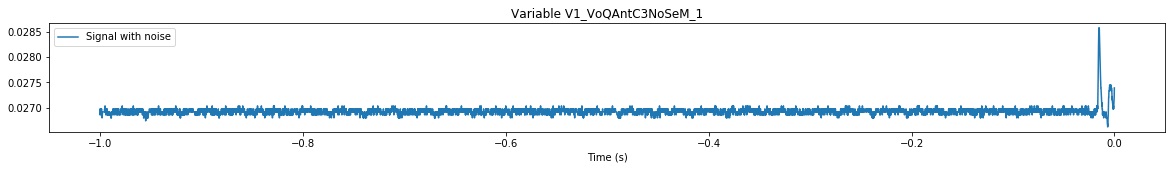

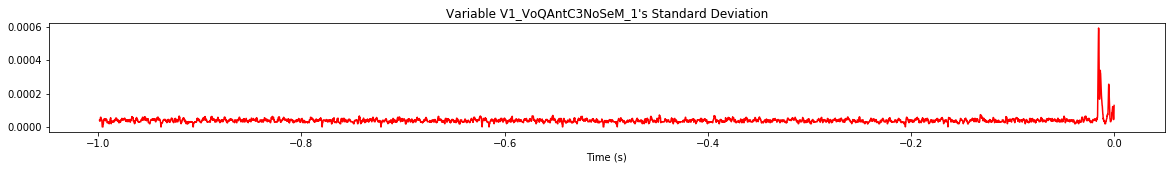

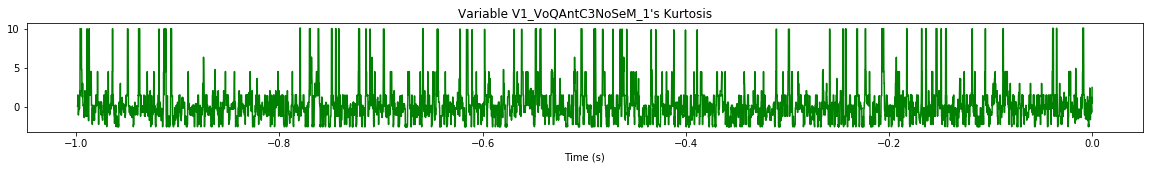

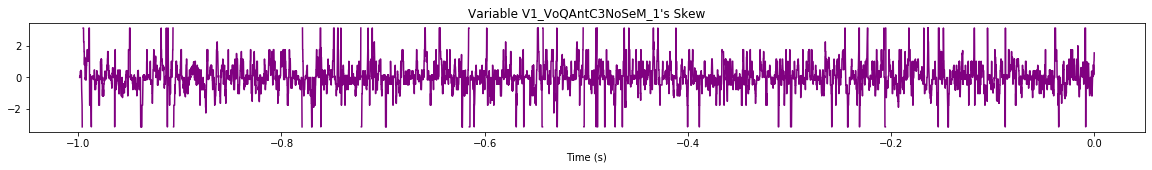

V1_VoQAntC3SkSeM_1


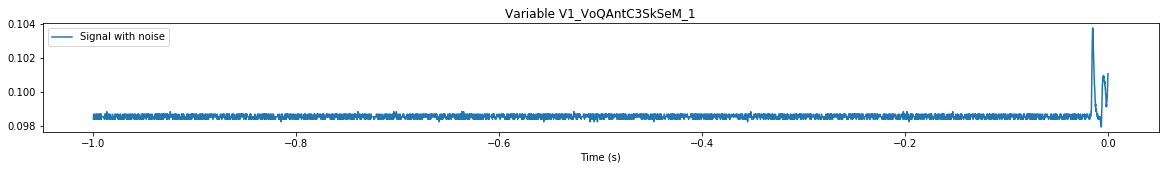

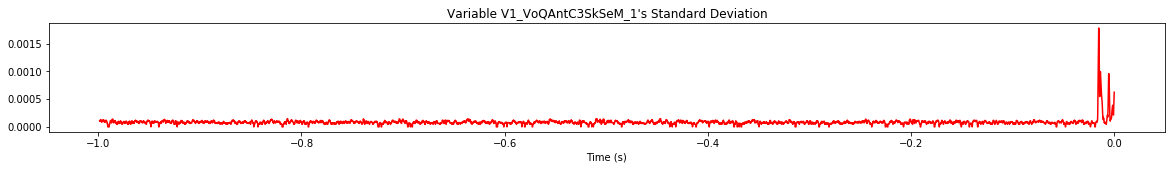

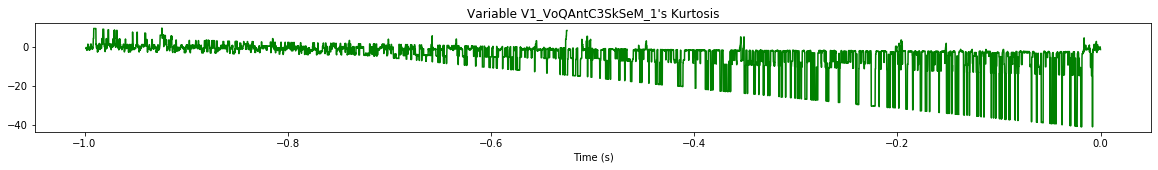

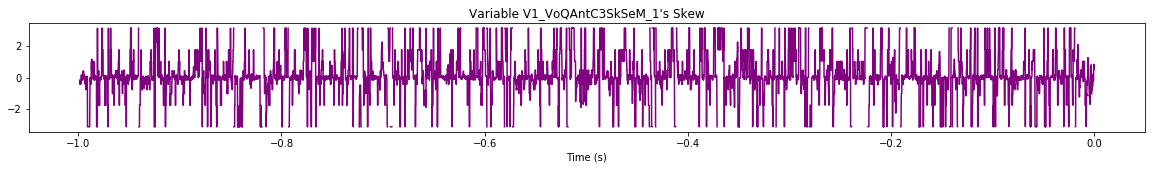

V1_VoQAntC2SkOcM_1


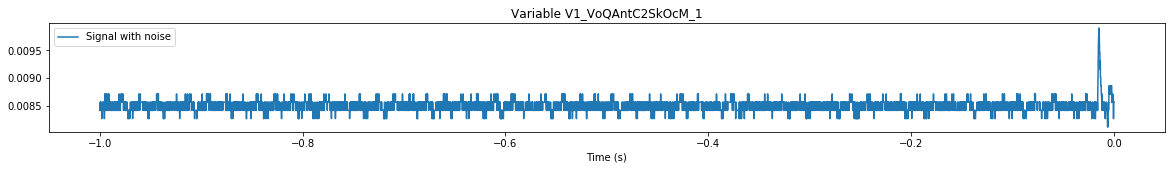

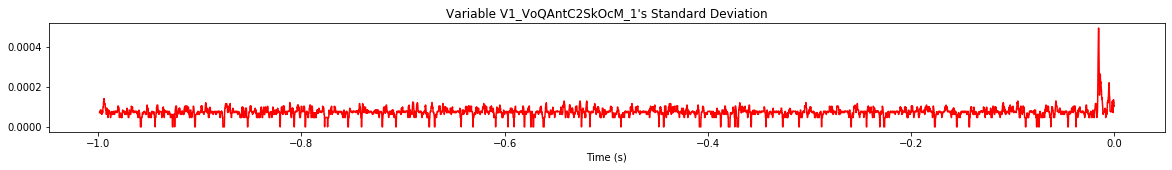

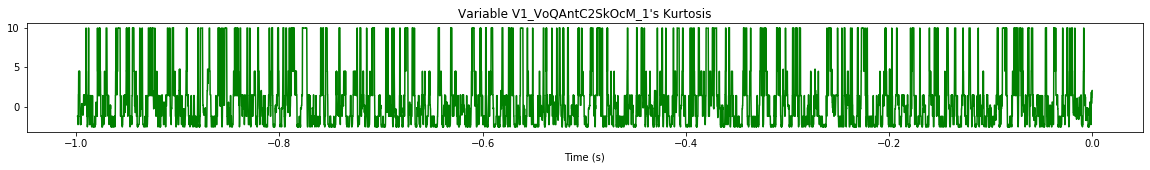

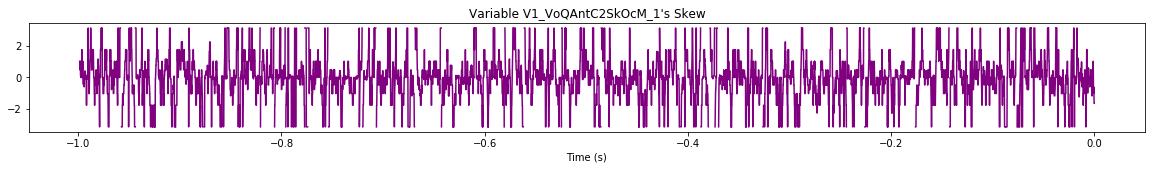

Flushing input history


In [7]:
#Plot all variables in the quench from (-1,0)
plot_statistics(quench1, variables = ["V1_VoQAntC3NoSeM_1", "V1_VoQAntC3SkSeM_1", "V1_VoQAntC2SkOcM_1"], 
                time_range = (-1,0), window = 10)

Quench's index: mqxfs1d.Quench.180424143318
V1_VoQAntC3SkSeM_1


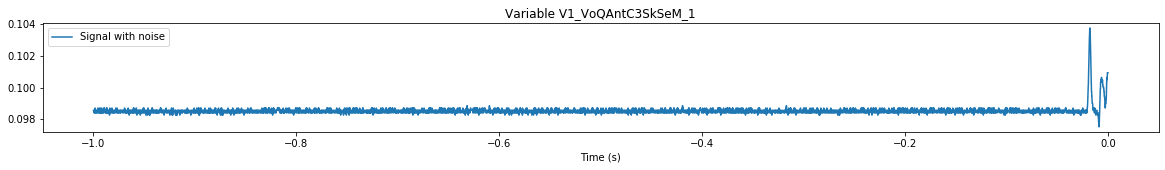

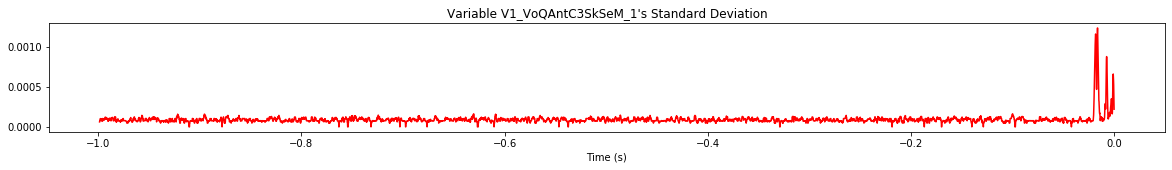

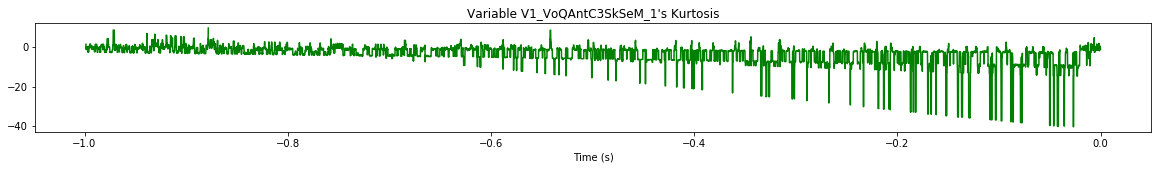

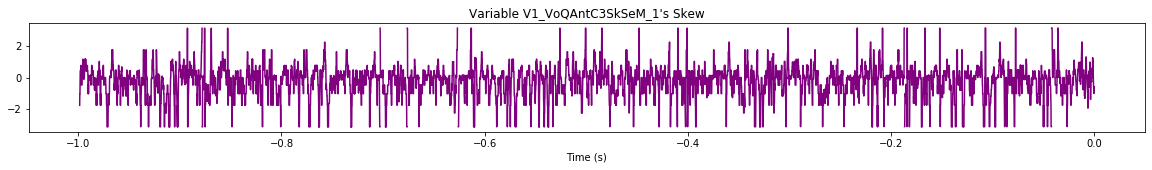

Flushing input history
Quench's index: mqxfs1d.Quench.180424164614
V1_VoQAntC3SkSeM_1


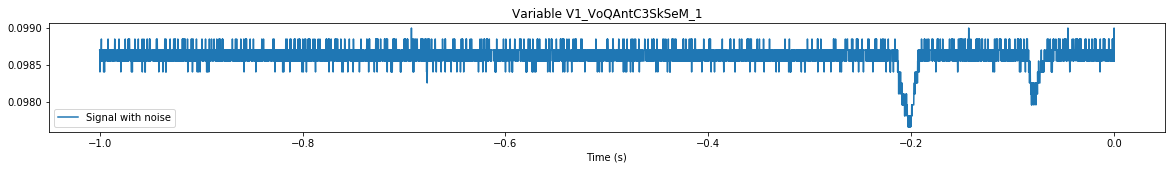

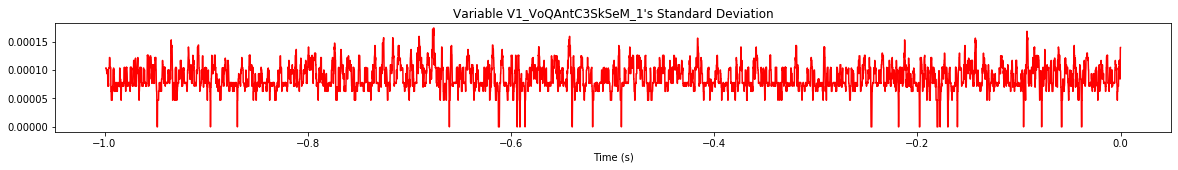

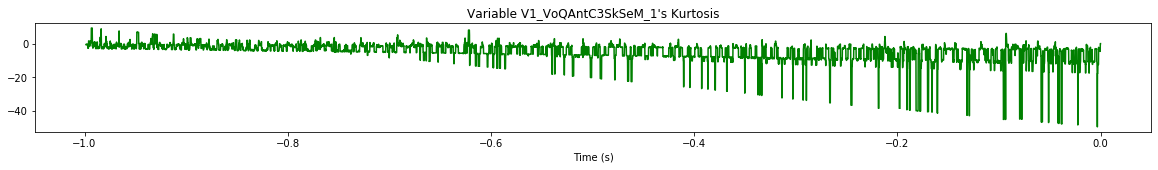

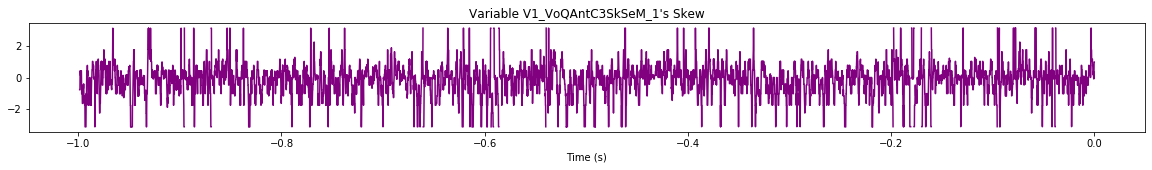

Flushing input history
Quench's index: mqxfs1d.Quench.180425123542
V1_VoQAntC3SkSeM_1


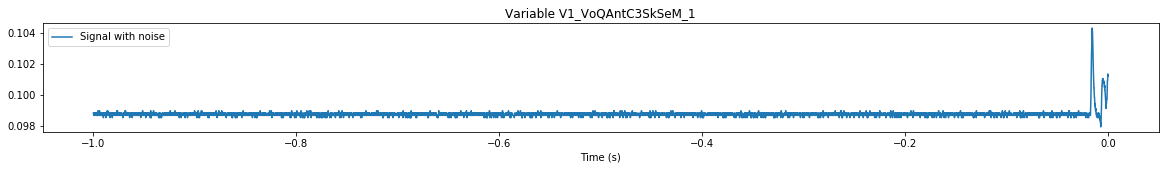

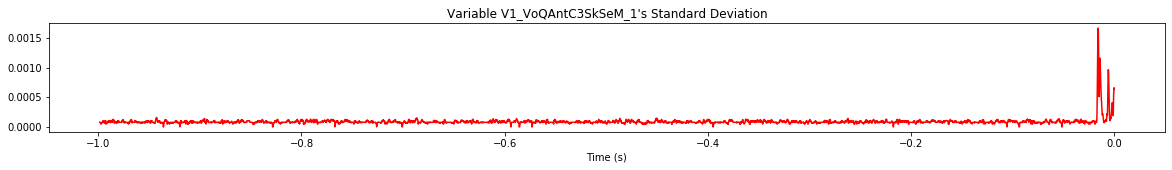

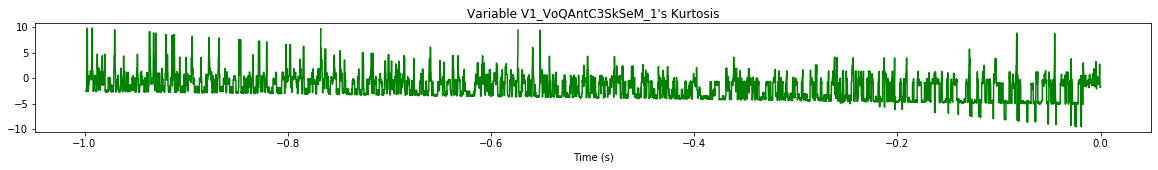

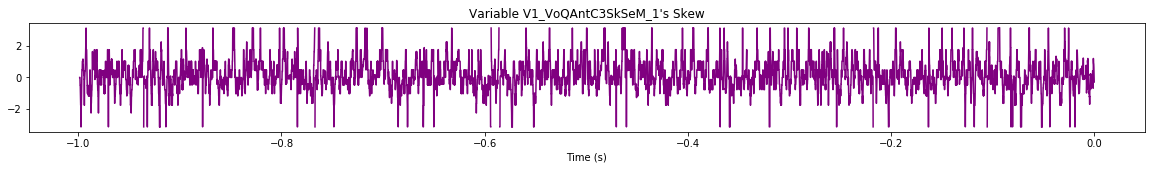

Flushing input history
Quench's index: mqxfs1d.Quench.180425153748
V1_VoQAntC3SkSeM_1


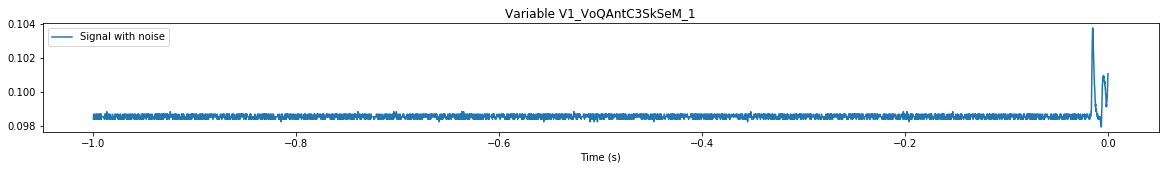

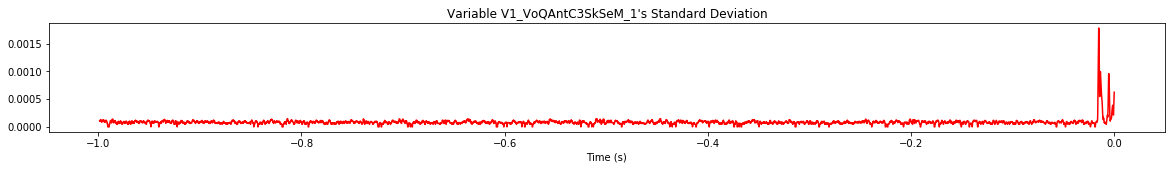

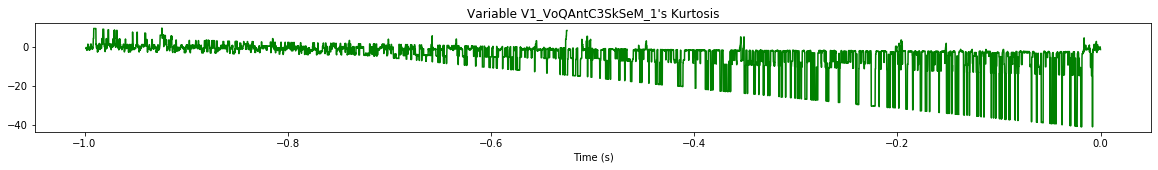

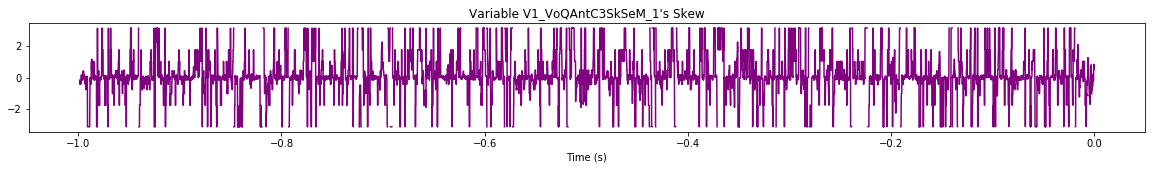

Flushing input history
Quench's index: mqxfs1d.Quench.180425182230
V1_VoQAntC3SkSeM_1


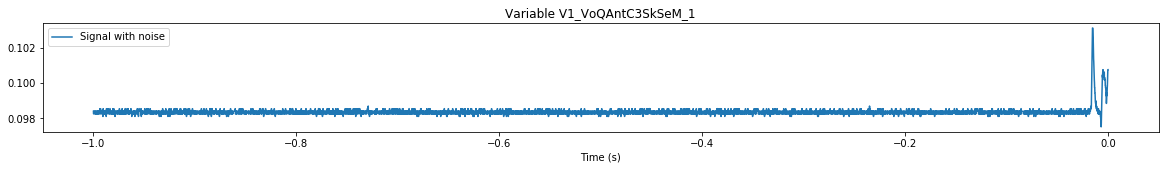

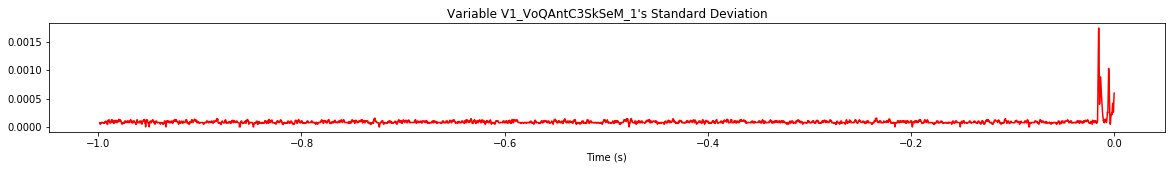

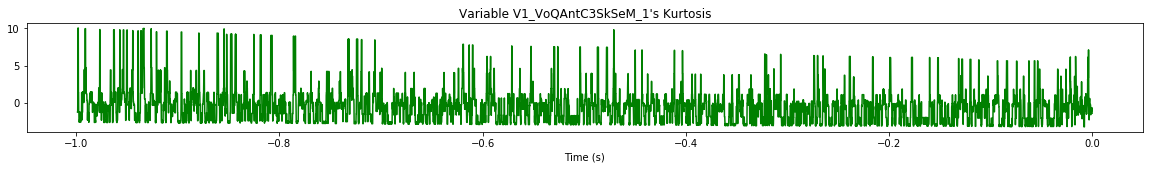

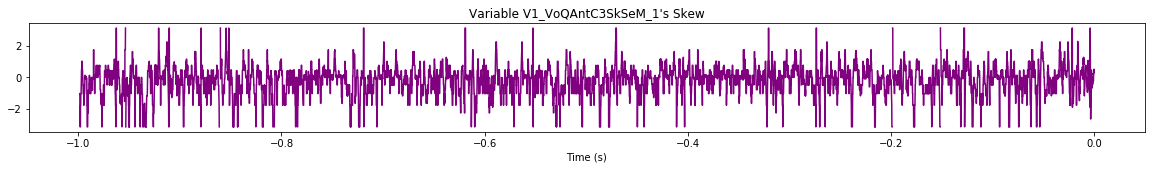

Flushing input history
Quench's index: mqxfs1d.Quench.180426092221
V1_VoQAntC3SkSeM_1


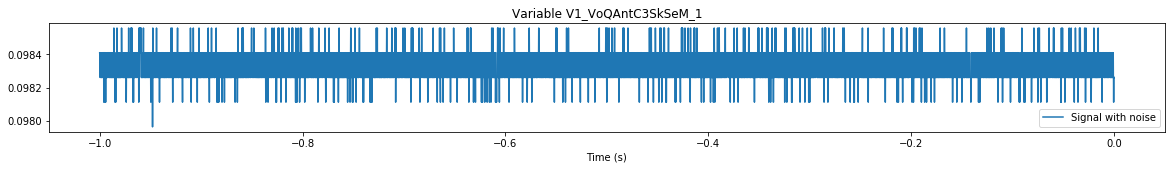

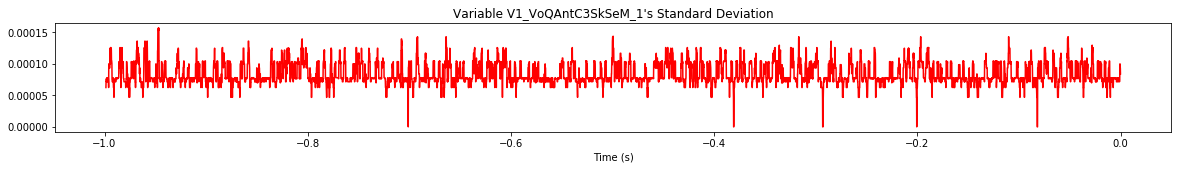

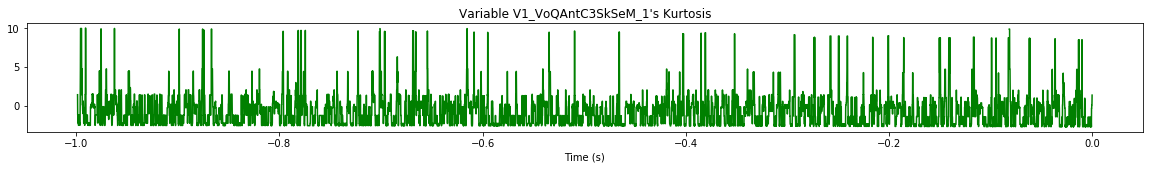

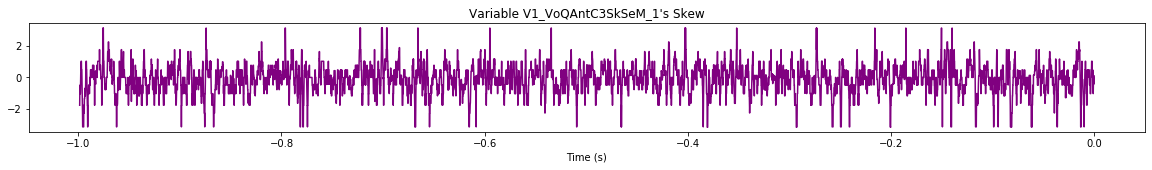

Flushing input history
Quench's index: mqxfs1d.Quench.180426115953
V1_VoQAntC3SkSeM_1


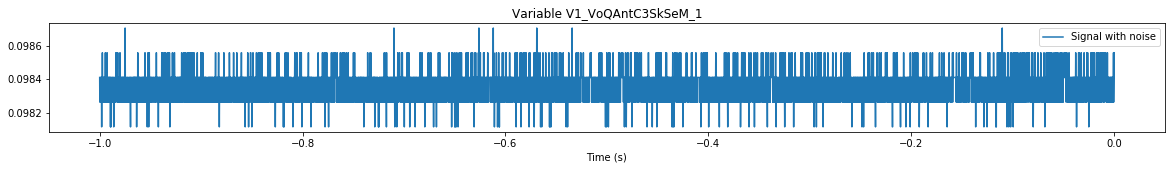

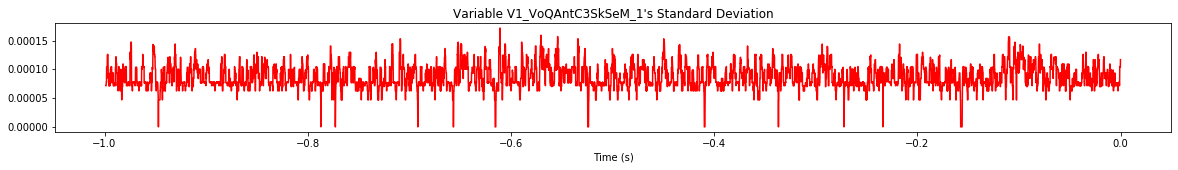

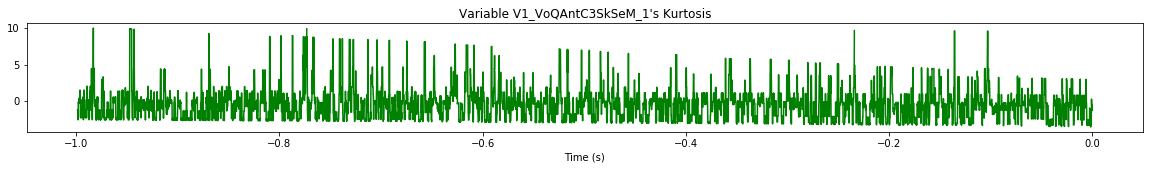

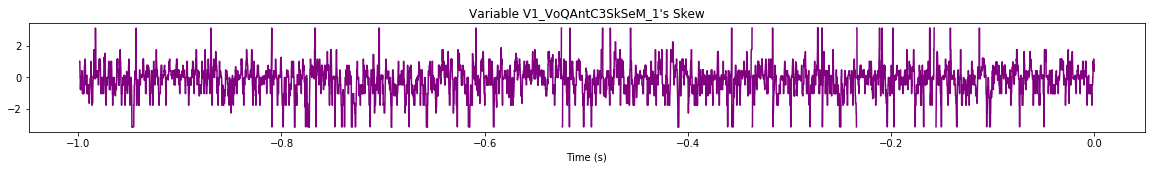

Flushing input history
Quench's index: mqxfs1d.Quench.180426144623
V1_VoQAntC3SkSeM_1


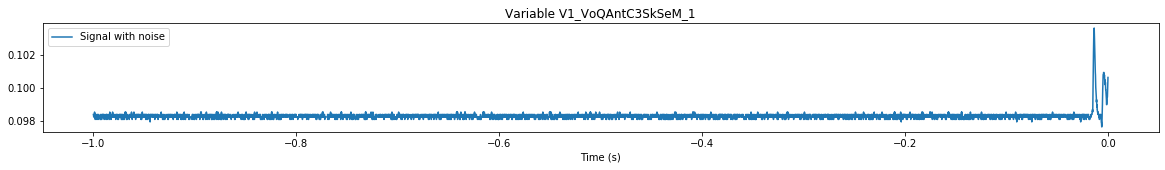

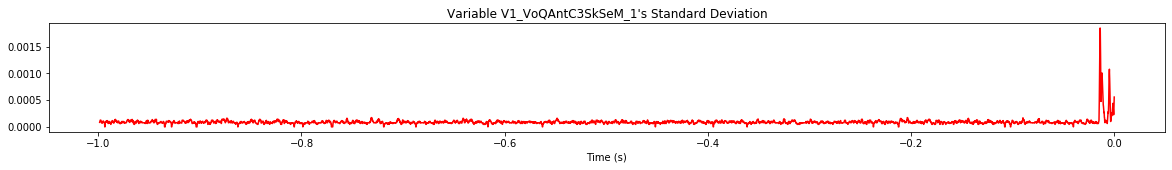

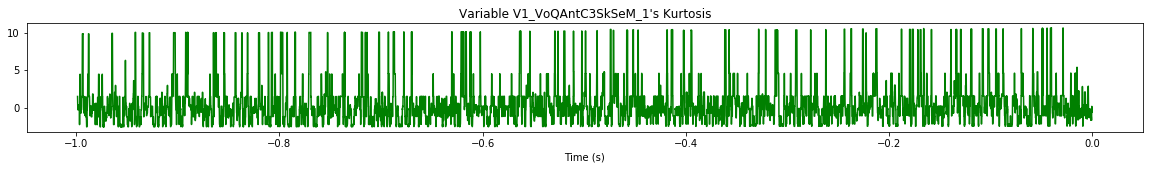

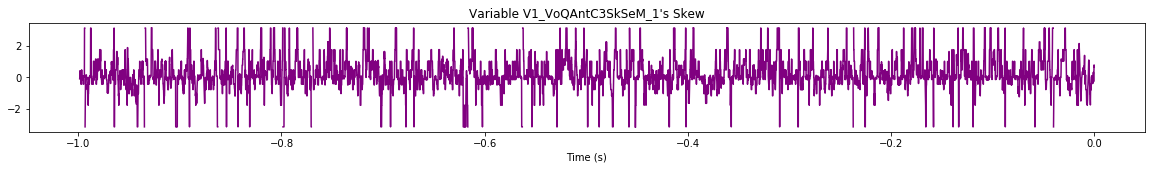

Flushing input history
Quench's index: mqxfs1d.Quench.180426171925
Quench's index: mqxfs1d.Quench.180427094832
V1_VoQAntC3SkSeM_1


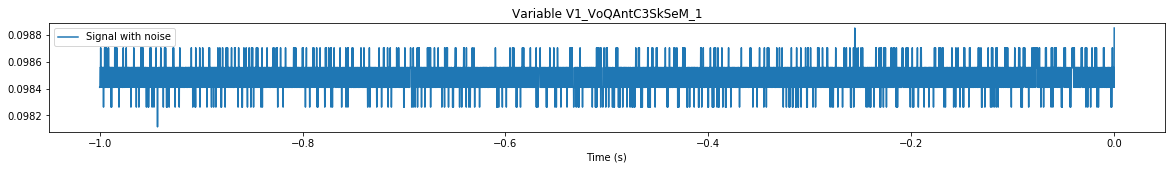

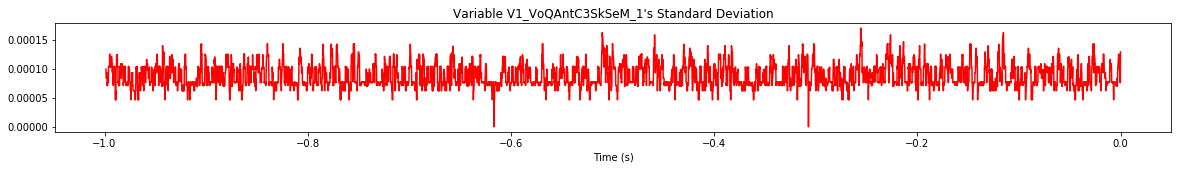

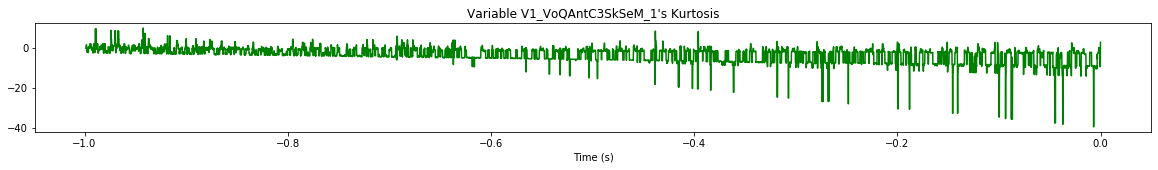

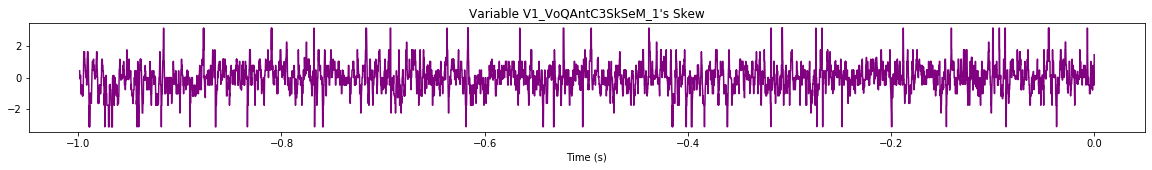

Flushing input history
Quench's index: mqxfs1d.Quench.180427124901
V1_VoQAntC3SkSeM_1


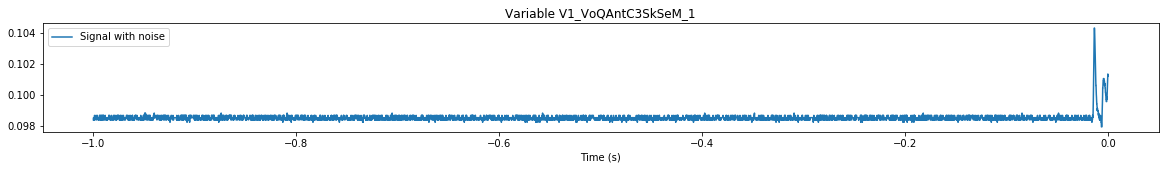

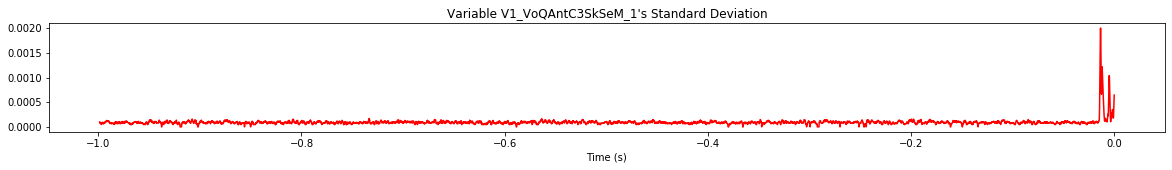

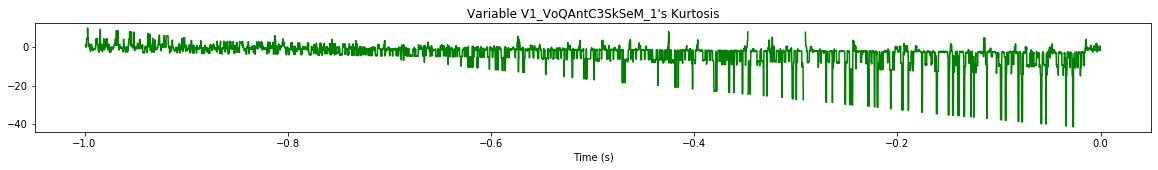

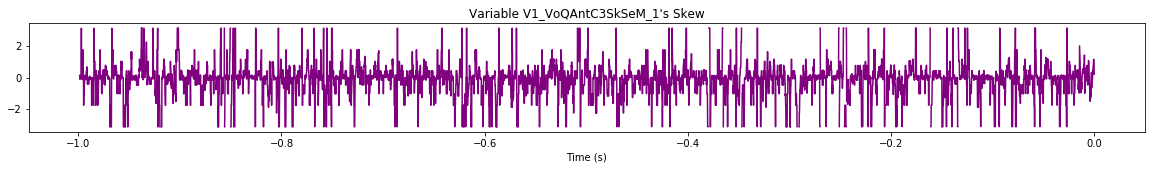

Flushing input history
Quench's index: mqxfs1d.Quench.180427154529
V1_VoQAntC3SkSeM_1


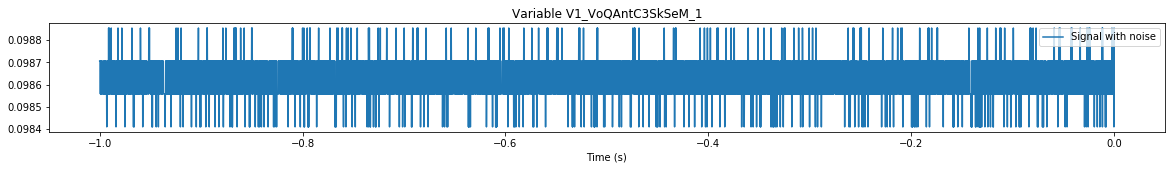

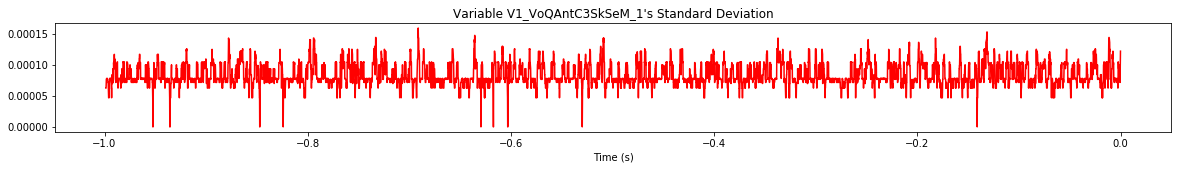

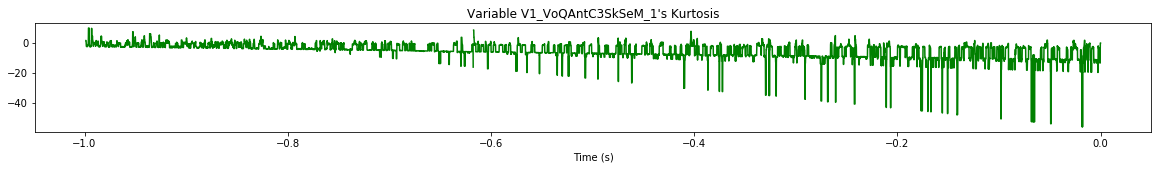

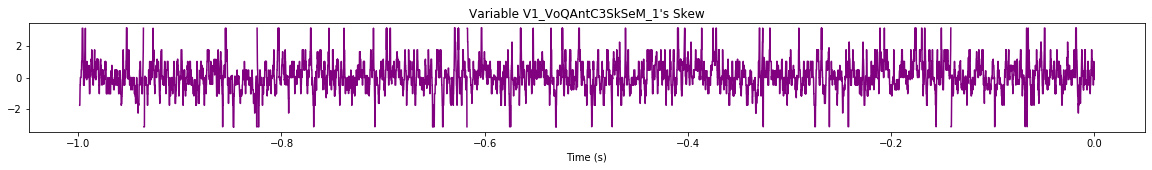

Flushing input history
Quench's index: mqxfs1d.Quench.180427184338
V1_VoQAntC3SkSeM_1


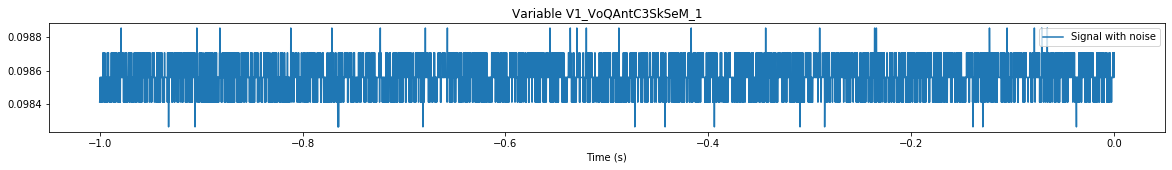

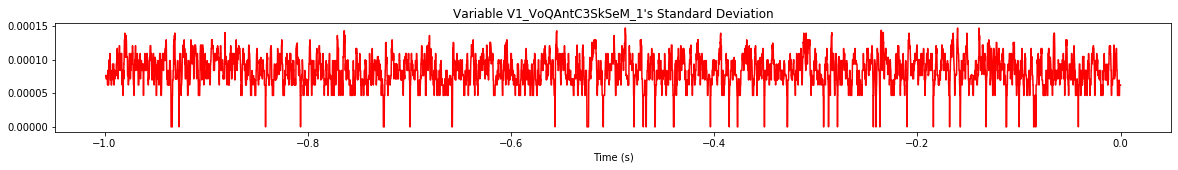

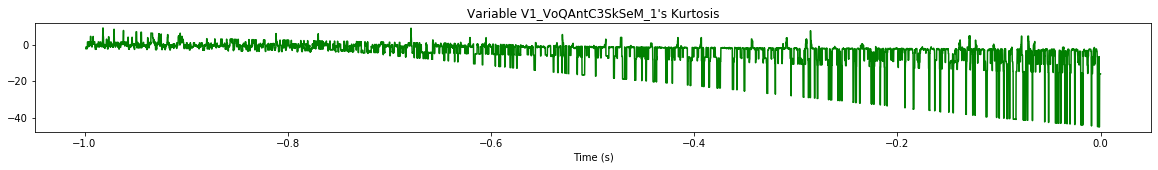

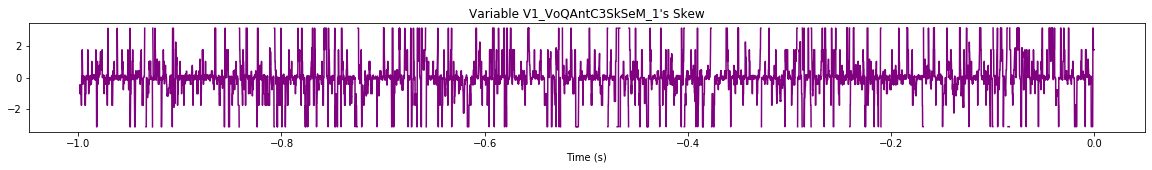

Flushing input history
Quench's index: mqxfs1d.Quench.180501130547
V1_VoQAntC3SkSeM_1


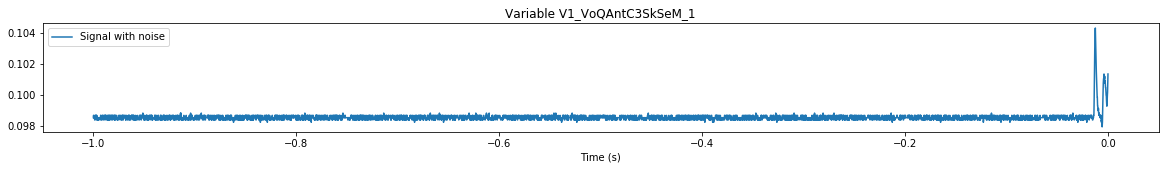

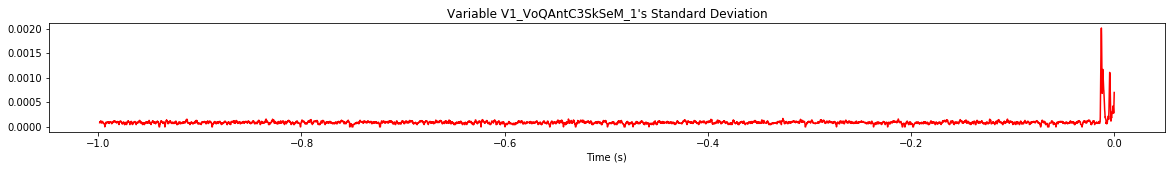

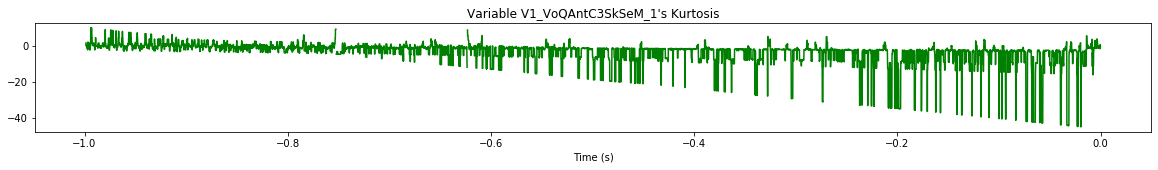

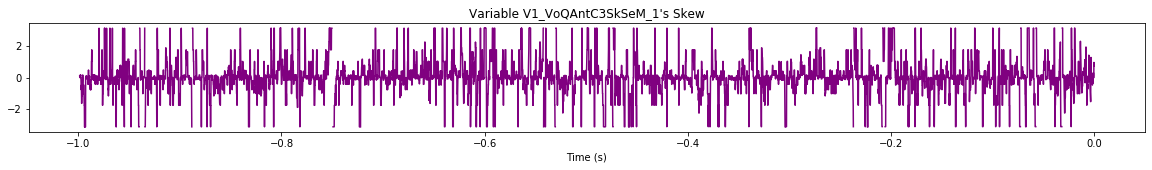

Flushing input history
Quench's index: mqxfs1d.Quench.180501160920
V1_VoQAntC3SkSeM_1


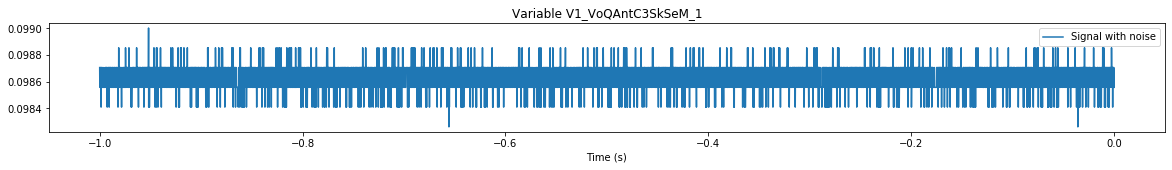

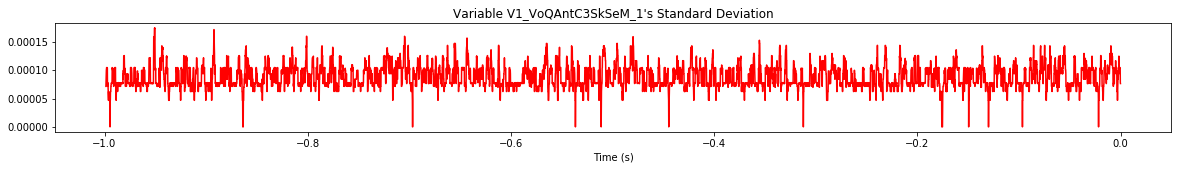

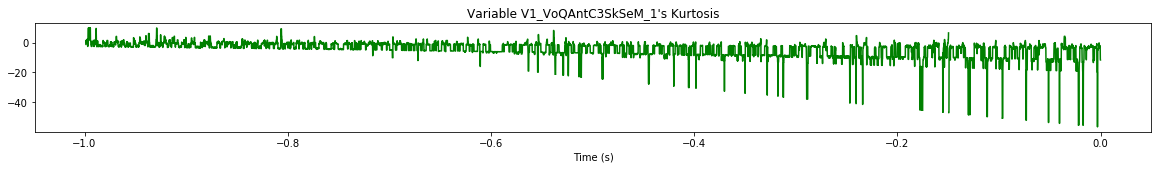

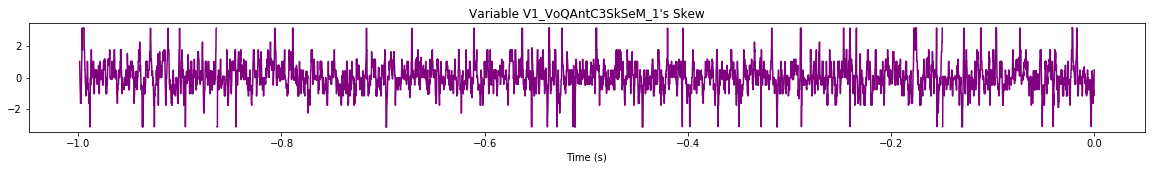

Flushing input history
Quench's index: mqxfs1d.Quench.180502104142
V1_VoQAntC3SkSeM_1


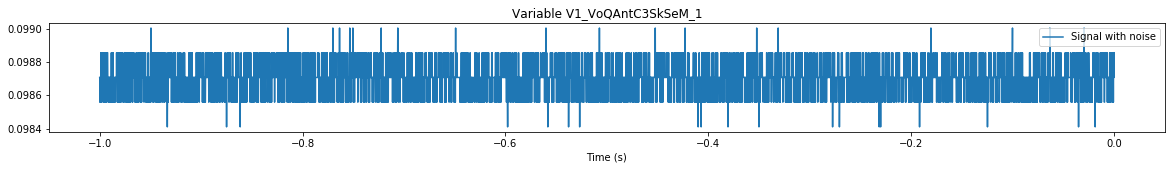

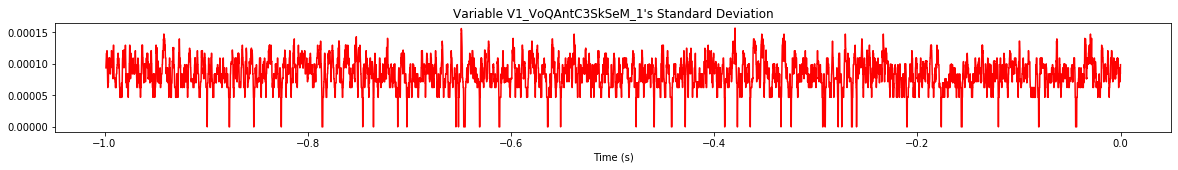

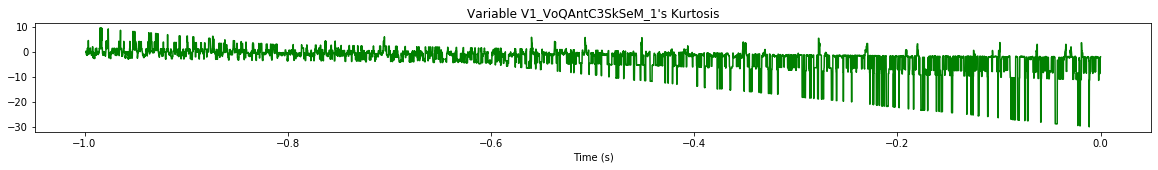

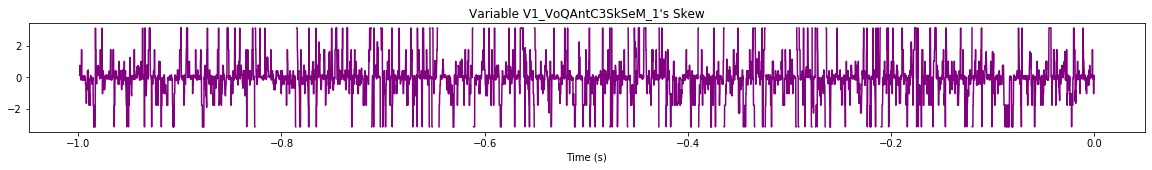

Flushing input history
Quench's index: mqxfs1d.Quench.180502143239
V1_VoQAntC3SkSeM_1


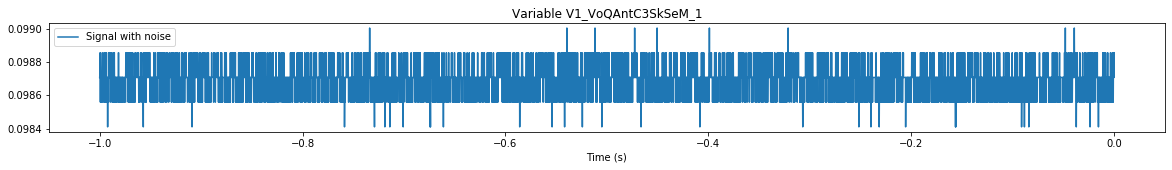

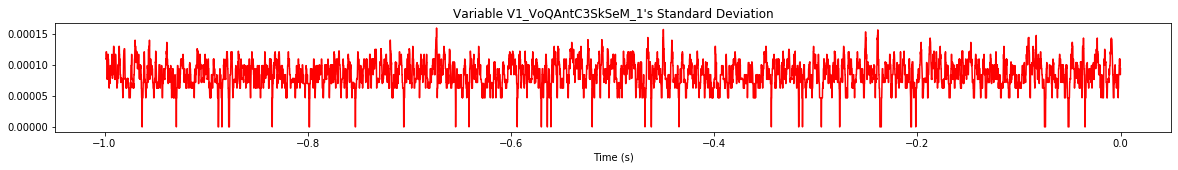

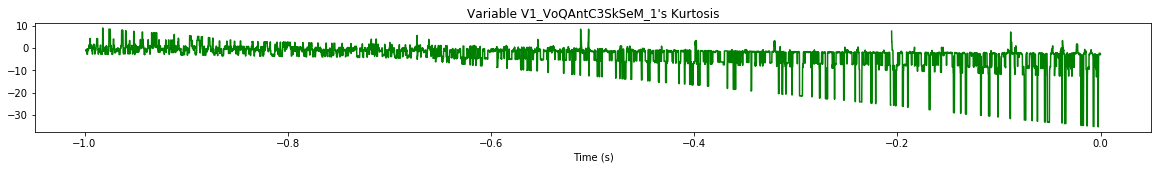

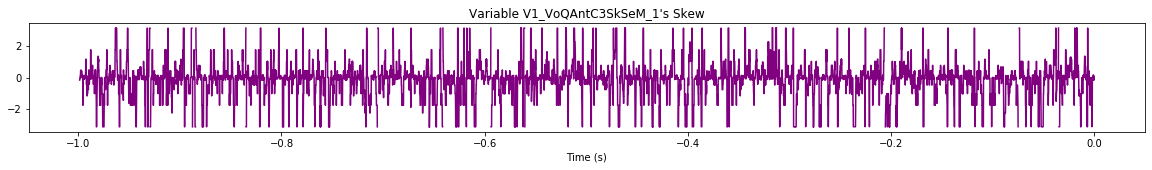

Flushing input history
Quench's index: mqxfs1d.Quench.180503174053
V1_VoQAntC3SkSeM_1


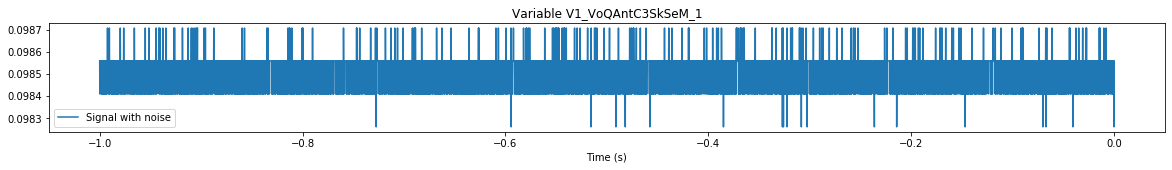

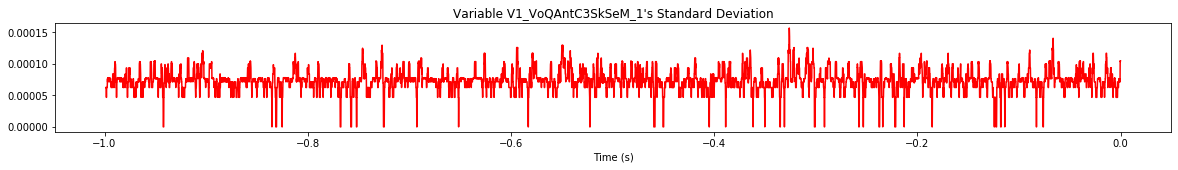

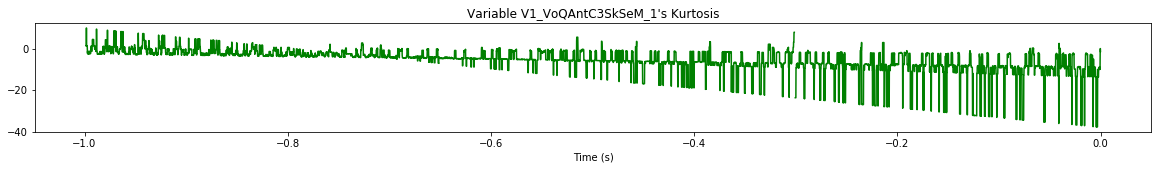

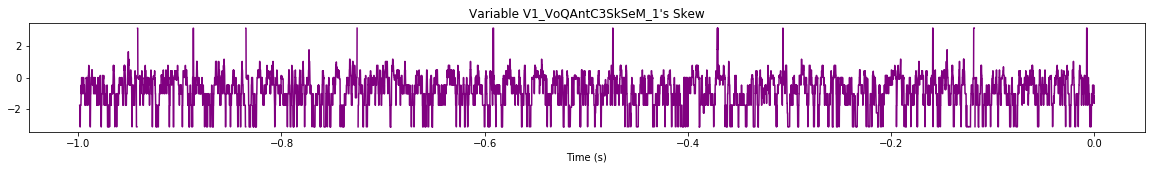

Flushing input history
Quench's index: mqxfs1d.Quench.180524152407
V1_VoQAntC3SkSeM_1


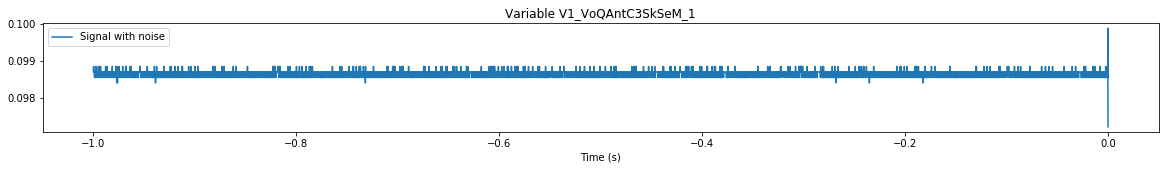

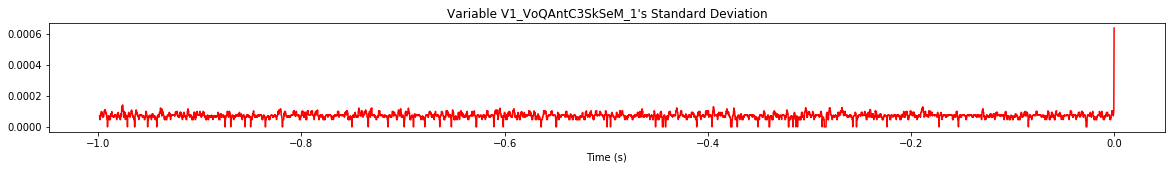

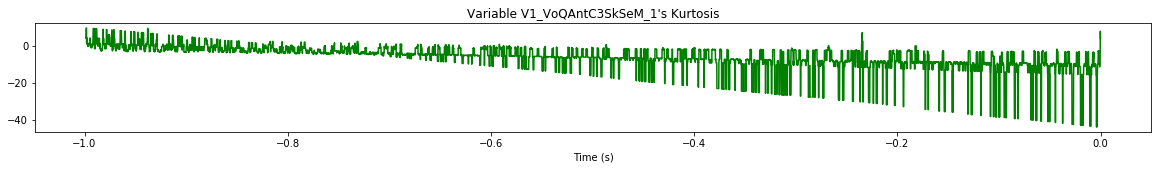

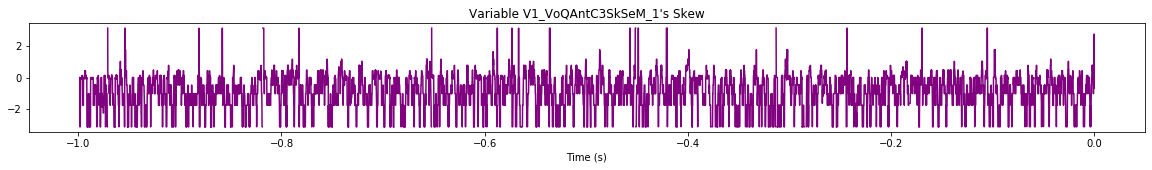

Flushing input history
Quench's index: mqxfs1d.Quench.180524165335
V1_VoQAntC3SkSeM_1


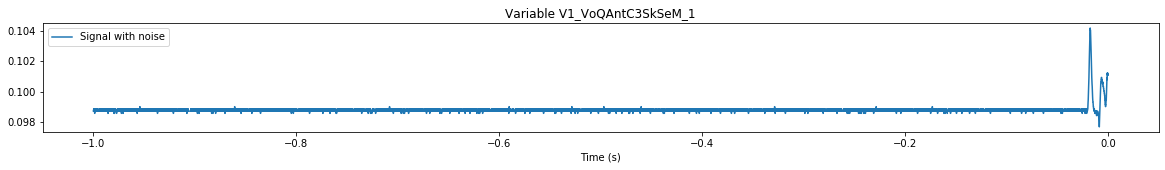

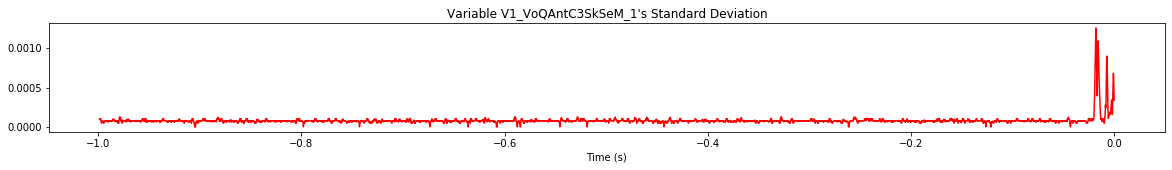

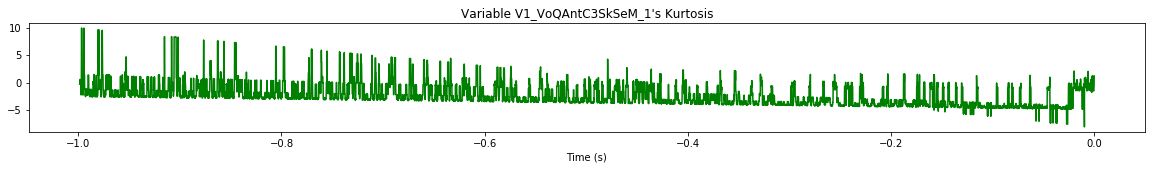

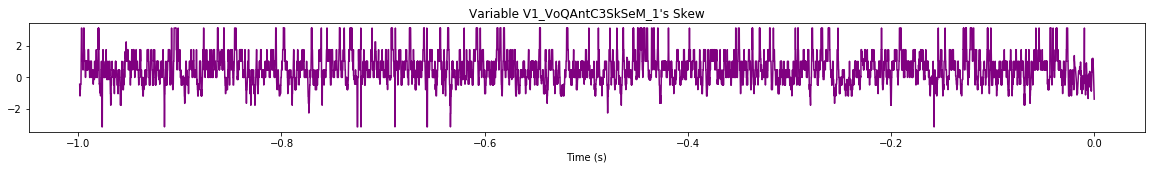

Flushing input history
Quench's index: mqxfs1d.Quench.180525093547
V1_VoQAntC3SkSeM_1


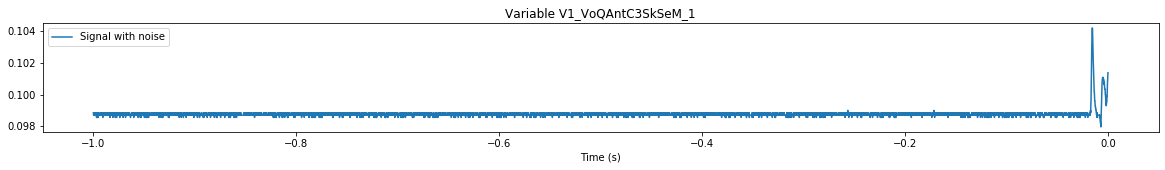

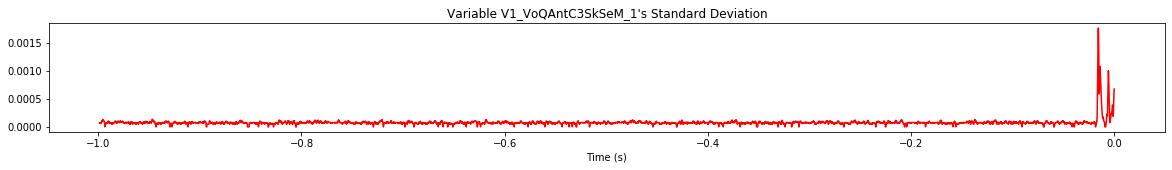

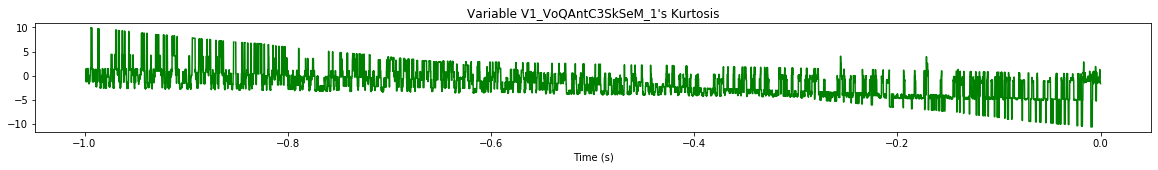

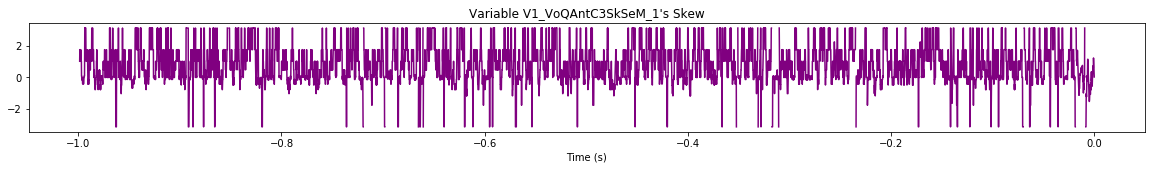

Flushing input history
Quench's index: mqxfs1d.Quench.180525125034
V1_VoQAntC3SkSeM_1


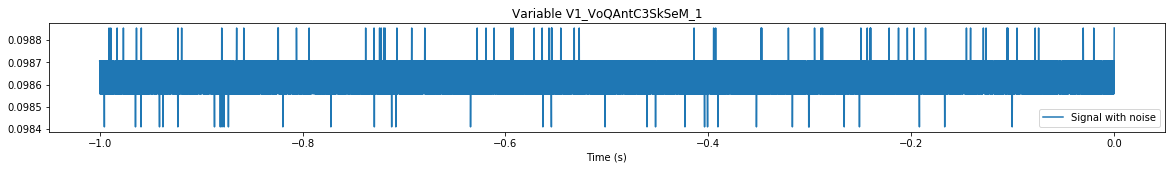

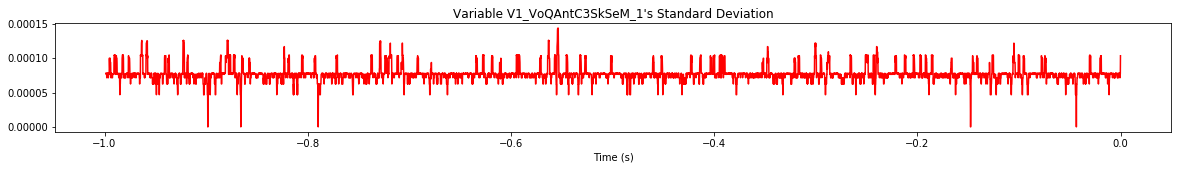

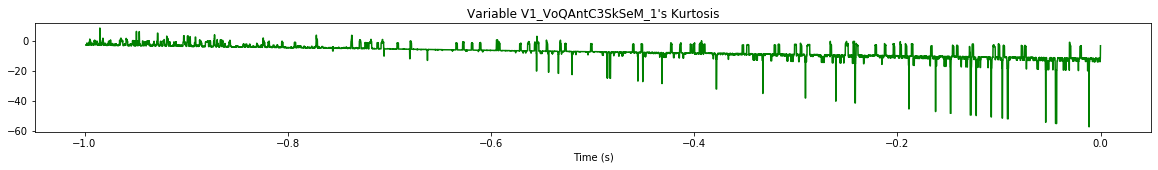

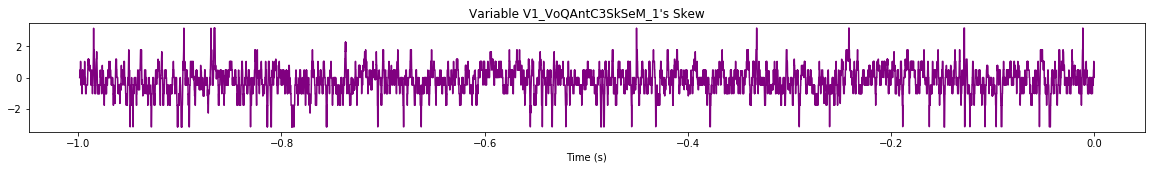

Flushing input history
Quench's index: mqxfs1d.Quench.180525172022
V1_VoQAntC3SkSeM_1


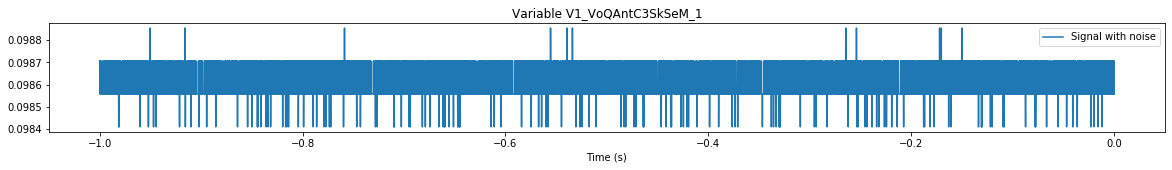

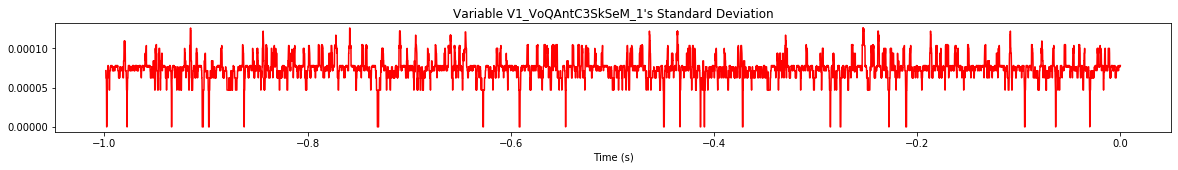

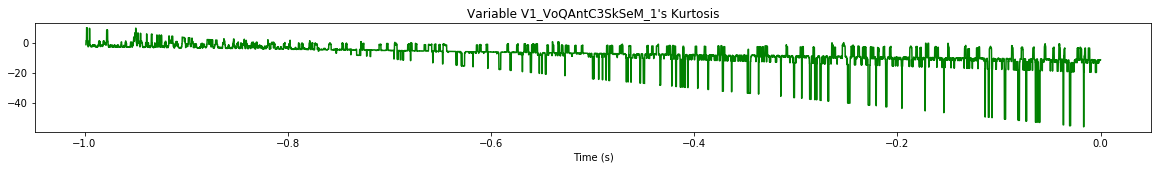

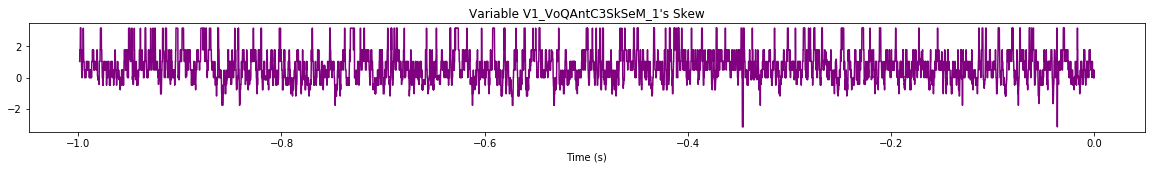

Flushing input history
Quench's index: mqxfs1d.Quench.180529123355
V1_VoQAntC3SkSeM_1


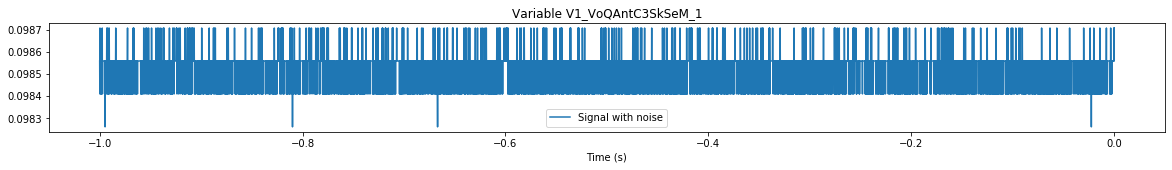

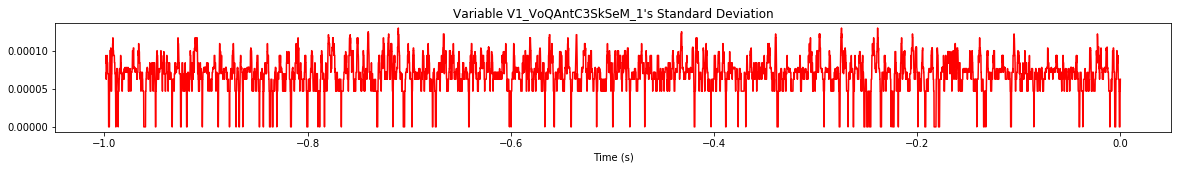

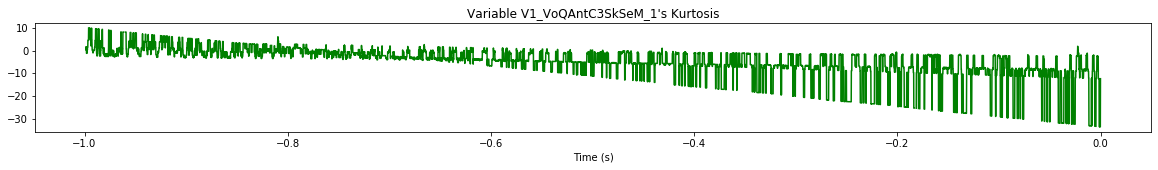

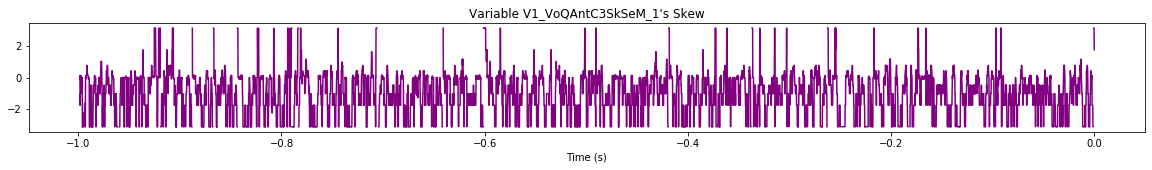

Flushing input history
Quench's index: mqxfs1d.Quench.180529153341
V1_VoQAntC3SkSeM_1


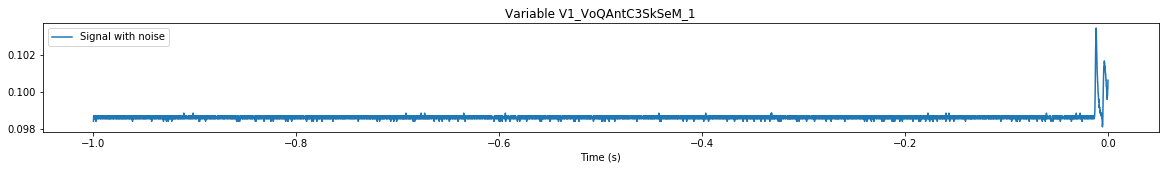

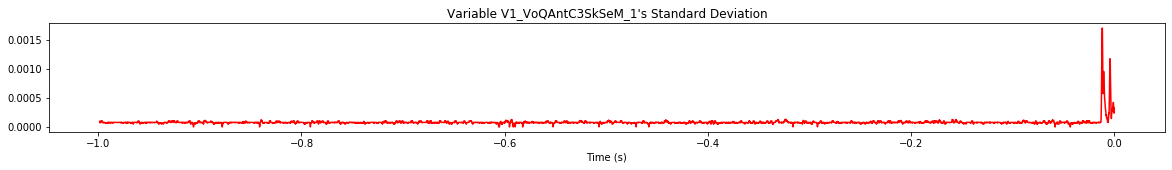

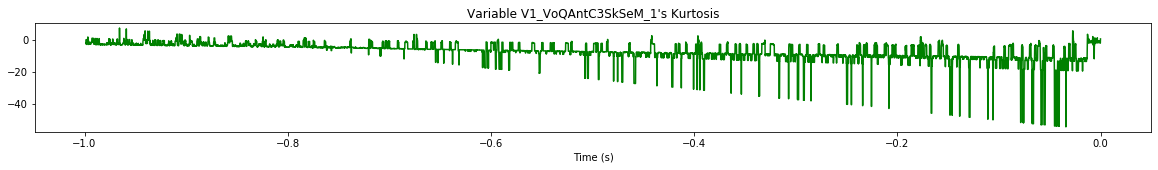

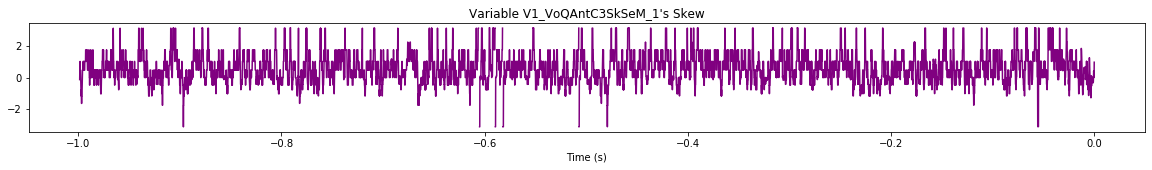

Flushing input history
Quench's index: mqxfs1d.Quench.180529180450
V1_VoQAntC3SkSeM_1


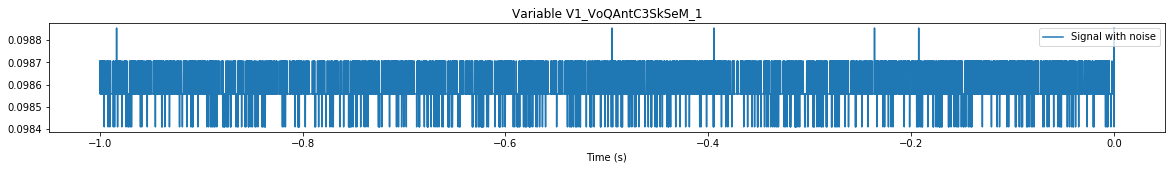

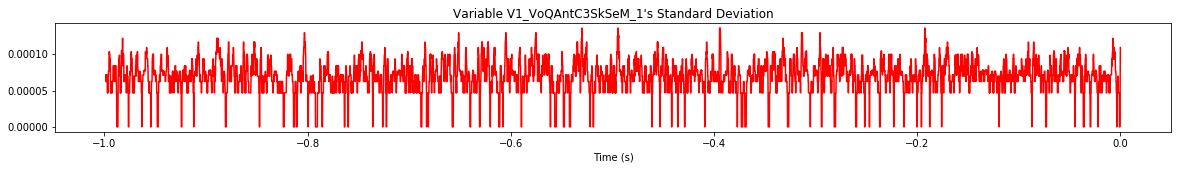

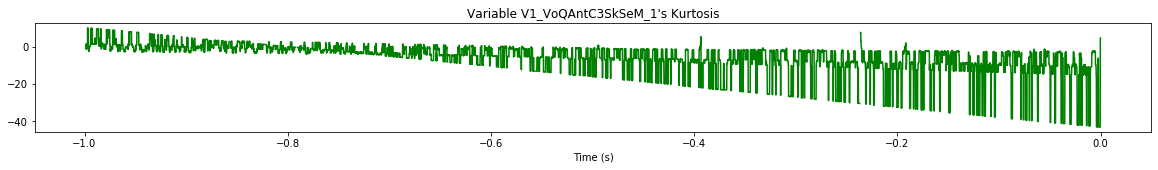

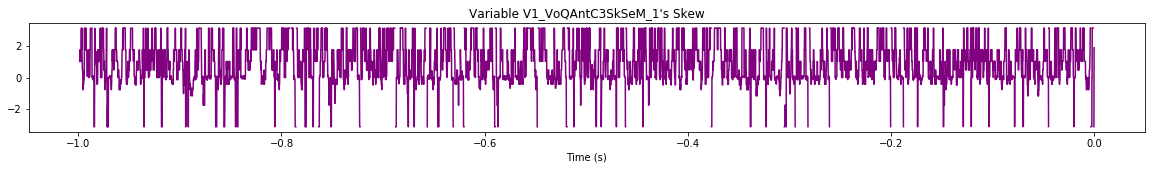

Flushing input history
Quench's index: mqxfs1d.Quench.180531114534
V1_VoQAntC3SkSeM_1


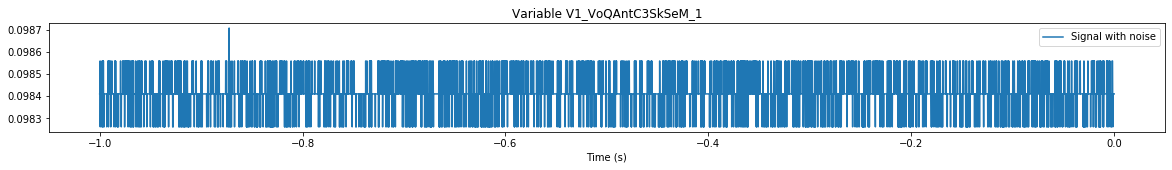

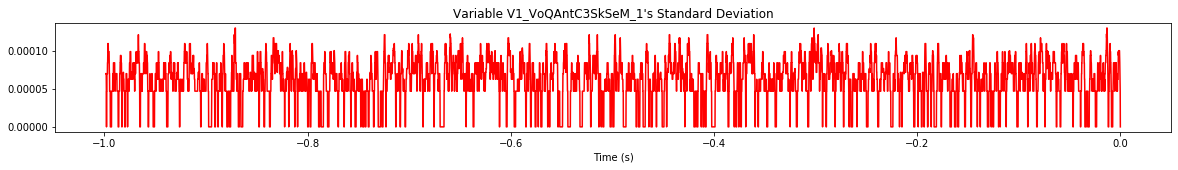

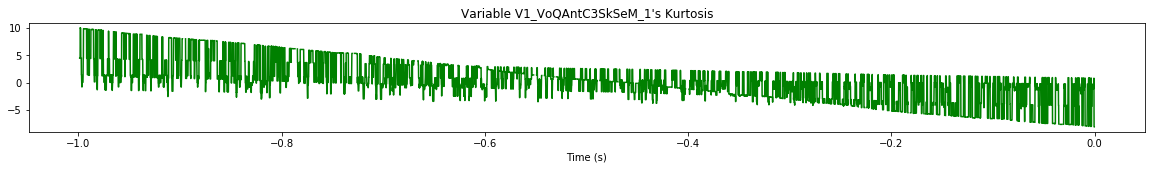

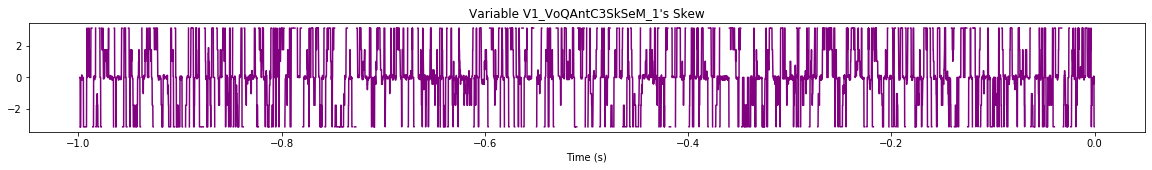

Flushing input history
Quench's index: mqxfs1d.Quench.180531182410
V1_VoQAntC3SkSeM_1


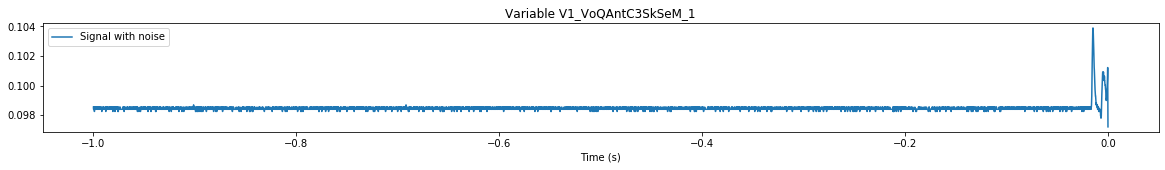

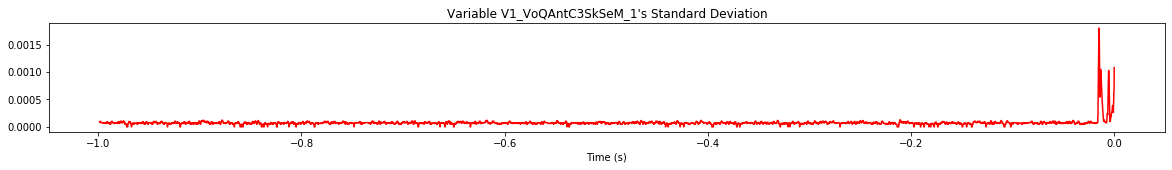

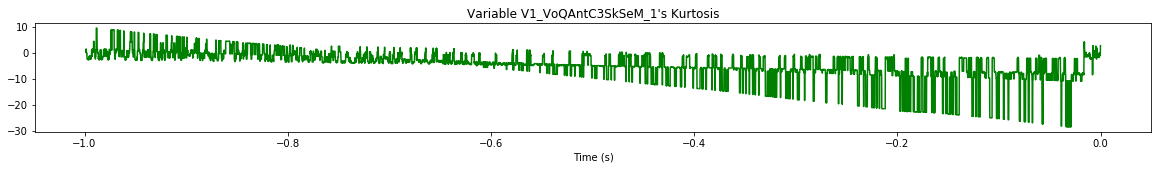

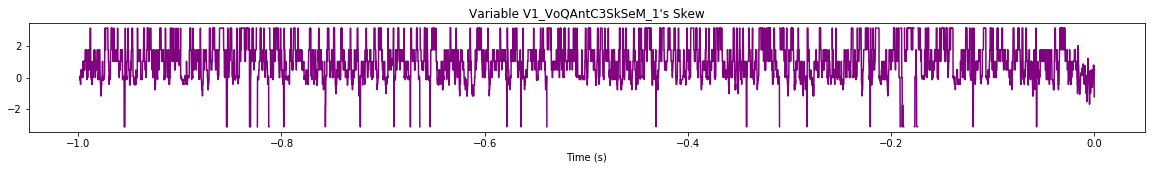

Flushing input history
Quench's index: mqxfs1d.Quench.180604121444
V1_VoQAntC3SkSeM_1


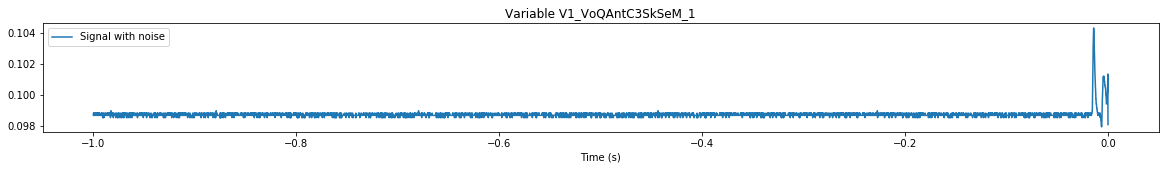

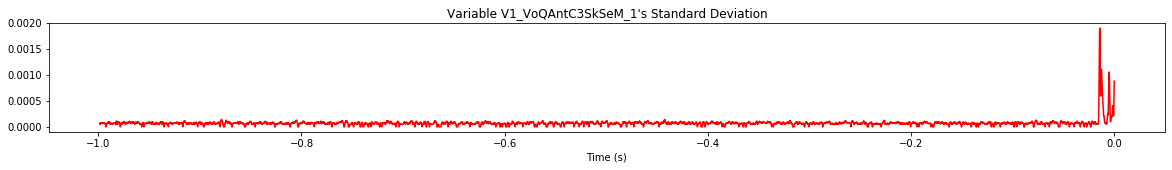

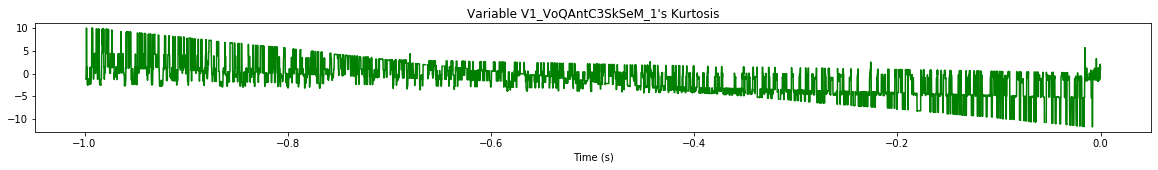

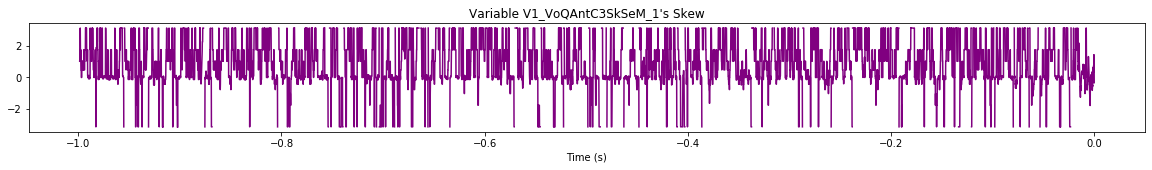

Flushing input history
Quench's index: mqxfs1d.Quench.180604152848
V1_VoQAntC3SkSeM_1


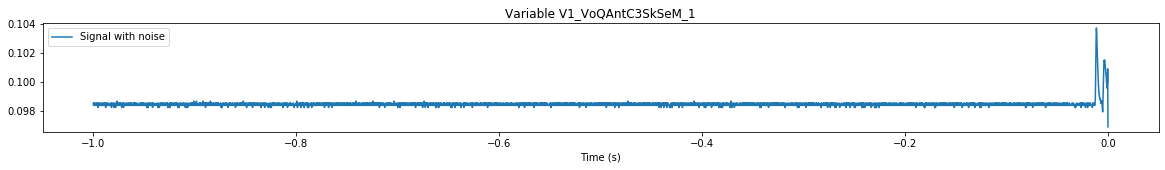

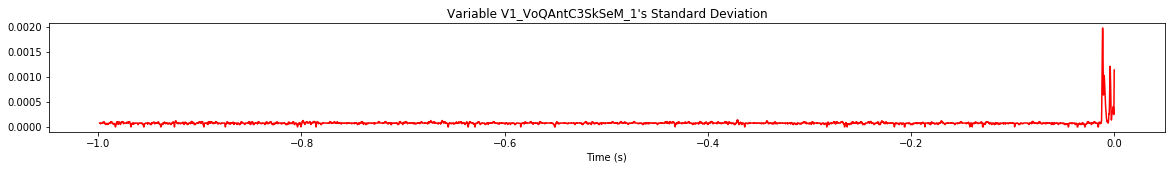

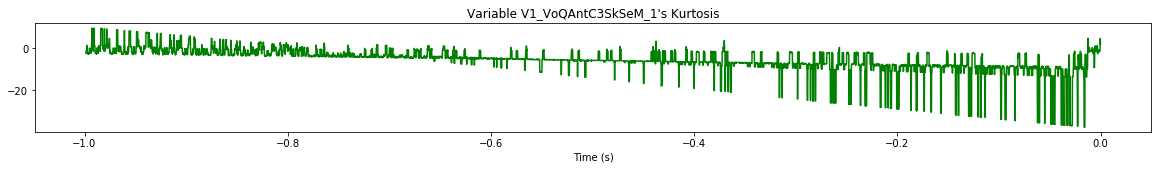

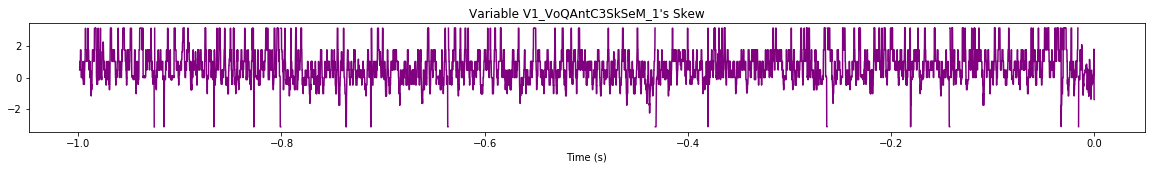

Flushing input history


In [8]:
#Plot this variable for all quenches in mqxfs1d
plot_variable(all_quench, ["V1_VoQAntC3SkSeM_1"],  time_range = (-1,0), window = 10)

### 1.2 Acoustic data

In [3]:
#load_and_plot("./data/Ramp4/", "ai0", time_range = (-50, 0), stat = True, window = 1000000)

In [4]:
#load_and_plot("./data/Ramp4/", "ai1", time_range = (-50, 0), stat = True, window = 1000000)

In [5]:
#load_and_plot("./data/Ramp4/", "ai2", time_range = (-50, 0), stat = True, window = 1000000)

In [6]:
#load_and_plot("./data/Ramp4/", "ai3", time_range = (-50, 0), stat = True, window = 1000000)

In [7]:
#load_and_plot("./data/Ramp4/", "ai4", time_range = (-50, 0), stat = True, window = 1000000)

## 2. MQXFS1D -- 25.Apr.2018 18:22 -- Ramp 5

### 1.1 Normal quench data 

In [ ]:
#quench2 = all_quench['']

### 1.2 Acoustic data

In [ ]:
#load_and_plot("./data/Ramp5/", "ai0", time_range = (-100, 0), stat = True)